# Building a Neural Network from scratch


In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
#!pip install mnist
import mnist
%matplotlib inline
plt.style.use('default')

# load data
train_images = mnist.train_images()
train_labels = mnist.train_labels()
num_train_images = len(train_labels)
test_images = mnist.test_images()
test_labels = mnist.test_labels()
num_test_images = len(test_images)

# print the data dimensions
print("Train Images Shape: "+str(train_images.shape))
print("Train Labels Shape: "+str(train_labels.shape))
print('Train Images DataType: '+str(train_images.dtype))
print("Test Images Shape: "+str(test_images.shape))
print("Test Labels Shape: "+str(test_labels.shape))
print('Test Images DataType: '+str(test_images.dtype))

Train Images Shape: (60000, 28, 28)
Train Labels Shape: (60000,)
Train Images DataType: uint8
Test Images Shape: (10000, 28, 28)
Test Labels Shape: (10000,)
Test Images DataType: uint8


Examine the data:


Text(0.5, 1.0, 'Image Label: 4')

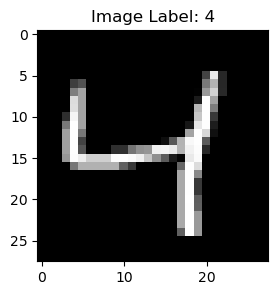

In [2]:
# display a single sample
idx = 2
plt.figure(figsize=(3, 3))
plt.imshow(train_images[idx, :, :], cmap="gray")
plt.title("Image Label: " + str(train_labels[idx]))

Here is a diagram of the neural network we will build:

<img src="Network_Diagram.png" width="800">


# Build the components of the network:


The ReLU function in
\begin{equation}
ReLU(x) =
\begin{cases}
0 & \textrm{if} & x < 0 \\
x & \textrm{if} & x > 0
\end{cases}
\end{equation}

The derivative is
\begin{equation}
\frac{\textrm{d}ReLU(x)}{\textrm{dx}} =
\begin{cases}
0 & \textrm{if} & x < 0 \\
1 & \textrm{if} & x > 0
\end{cases}
\end{equation}


In [3]:
# define the nonlinear ReLU function
def ReLU(x):
    return np.max((0, x))

The softmax function is
\begin{equation}
\sigma(x)=(\sigma_1(x),\sigma_2(x),...,\sigma_m(x)), \textrm{ where } \sigma_i(x)=\frac{e^{x_i}}{\sum_j e^{x_j}}.
\end{equation}
Note that the components sum to 1, so this is a probability distribution.


Observe that for $i\neq j$:
\begin{equation}
\frac{d \sigma_j(x)}{d x_i} = -\sigma_j(x)\sigma_i(x)
\end{equation}
and
\begin{equation}
\frac{d \sigma_j(x)}{d x_j} = \sigma_j(x) - \sigma_j(x)^2
\end{equation}


In [4]:
# define the softmax function.
# This converts a vector of K real numbers into a probability distribution of K possible outcomes.
# It is a generalization of the logistic function to multiple dimensions, and used in multinomial logistic regression.
def softmax(inputs):
    outputs = np.exp(inputs) / np.sum(np.exp(inputs))
    return outputs

In [5]:
softmax(np.array([-1, 3, 12, -4]))

array([2.26004513e-06, 1.23394283e-04, 9.99874233e-01, 1.12521022e-07])

Now we can put these pieces together to make a layer in the form of a Python class.


In [6]:
# define a layer class
class FClayer_Original:
    def __init__(self, numInputs, numNodes):
        self.numInputs = numInputs
        self.numNodes = numNodes
        self.weights = np.random.normal(0.0, 0.05, size=(numNodes, numInputs))
        self.biases = np.zeros(numNodes)

    def apply(self, inputs):
        if len(inputs) != self.numInputs:
            # check here so if there is an error we get told nicely about it.
            print("WARNING: Inputs to layer wrong size for the layer.")
            output = np.zeros(self.numNodes)
            return output
        # create a vector to hour the output of the layer
        output = np.zeros(self.numNodes)
        # Apply weights and biases
        x = np.matmul(self.weights, inputs) + self.biases
        # Apply the nonlinear function to each node
        for i in range(self.numNodes):
            output[i] = ReLU(x[i])
        return output

In [7]:
# Modified code to accept the different weight initializations
import numpy as np


def ReLU(x):
    return max(0, x)


class FClayer:
    def __init__(self, numInputs, numNodes, weight_init_method="random"):
        self.numInputs = numInputs
        self.numNodes = numNodes
        self.weights = None
        self.biases = np.zeros(numNodes)

        if weight_init_method == "random":
            self.initialize_weights_random()
        elif weight_init_method == "xavier":
            self.initialize_weights_xavier()
        elif weight_init_method == "he":
            self.initialize_weights_he()
        else:
            raise ValueError("Invalid weight initialization method")

    def initialize_weights_random(self):
        self.weights = np.random.normal(0.0, 0.05, size=(self.numNodes, self.numInputs))

    def initialize_weights_xavier(self):
        self.weights = np.random.normal(
            0.0, np.sqrt(1 / self.numInputs), size=(self.numNodes, self.numInputs)
        )

    def initialize_weights_he(self):
        self.weights = np.random.normal(
            0.0, np.sqrt(2 / self.numInputs), size=(self.numNodes, self.numInputs)
        )

    def apply(self, inputs):
        if self.weights is None:
            raise ValueError("Weights have not been initialized.")

        if len(inputs) != self.numInputs:
            print("WARNING: Inputs to layer wrong size for the layer.")
            output = np.zeros(self.numNodes)
            return output

        output = np.zeros(self.numNodes)
        x = np.matmul(self.weights, inputs) + self.biases

        for i in range(self.numNodes):
            output[i] = ReLU(x[i])

        return output

In [8]:
layer = FClayer(5, 3)

In [9]:
# Attempting the new FClayer implementation with xavier Weight initialization
layer = FClayer(5, 3, weight_init_method="xavier")

In [10]:
# Attempting the new FClayer implementation with he Weight initialization
layer = FClayer(5, 3, weight_init_method="he")

In [11]:
layer.weights

array([[ 0.29328304,  0.55348788,  0.51506414, -0.62289542, -0.50415138],
       [-0.44895156,  1.18152126,  0.13688301, -0.77349774, -0.13887591],
       [-0.39108708,  0.17511652,  0.898093  , -0.51636639, -0.26680709]])

In [12]:
28 * 28

784

# Build the network:


In [13]:
# define two hidden layers and an output layer
layer1 = FClayer(28 * 28, 30, weight_init_method="he")
layer2 = FClayer(30, 10, weight_init_method="he")
layerFinal = softmax

In [14]:
# define the network
class network2layers:
    def __init__(self, layer1, layer2, layerFinal):
        self.layer1 = layer1
        self.layer2 = layer2
        self.layerFinal = layerFinal

    def apply(self, inputs):
        self.inputs = inputs
        # This determines the network 'architecture'
        self.out1 = self.layer1.apply(self.inputs)
        self.out2 = self.layer2.apply(self.out1)
        self.outFinal = self.layerFinal(self.out2)
        return self.outFinal

    def train(self, obs, y, alpha):
        # this is a placeholder method that we will modify later.
        # for now we just set the parameters equal to themselves instead of updating them
        #   obs = one observation (input into the network)
        #   y = the truth value for the obs
        #   alpha = the training rate
        self.layer1.weights = self.layer1.weights
        self.layer1.biases = self.layer1.biases
        self.layer2.weights = self.layer2.weights
        self.layer2.biases = self.layer2.biases


# create an instance of this network
# (the weights will be randomly selected since it is not trained)
network = network2layers(layer1, layer2, layerFinal)

# Examine the network:


[[0, 255, 0], [0, 100, 0], [0, 0, 0]]


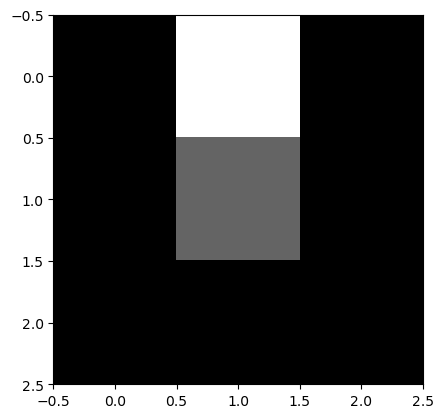

In [15]:
im = [[0, 255, 0], [0, 100, 0], [0, 0, 0]]
plt.imshow(im, cmap="gray")
print(im)

In [16]:
# look at the output of each layer for a test image
idx = 0  # (use the fisrt image/observation)
out1 = network.layer1.apply(train_images[idx, :, :].flatten() / 255.0)
print("Layer 1 output: " + str(out1))
out2 = network.layer2.apply(out1)
print("Layer 2 output: " + str(out2))
outFinal = network.layerFinal(out2)
print("Final layer output: " + str(outFinal))

Layer 1 output: [0.         0.         0.13692905 0.         0.         0.
 0.19740444 0.37041341 0.         0.         0.         0.81706798
 0.02132227 0.79487345 0.12347877 0.         0.54899322 0.
 0.         0.         0.         0.10662051 0.03741886 0.
 0.         0.47731574 0.17031522 0.         0.12785346 0.77335028]
Layer 2 output: [0.45572172 0.         0.         0.         0.11784159 0.
 0.39242987 0.         0.         0.        ]
Final layer output: [0.14104607 0.08942183 0.08942183 0.08942183 0.10060545 0.08942183
 0.13239564 0.08942183 0.08942183 0.08942183]


In [17]:
# view the output of the network applied to a single image
# (this is the same as the output from the final layer above)
network.apply(train_images[2, :, :].flatten() / 255.0)

array([0.13813687, 0.08026824, 0.08817238, 0.13758325, 0.09247254,
       0.08026824, 0.08026824, 0.10690867, 0.11565332, 0.08026824])

In [18]:
# can get individual layer outputs from the network (since we saved them withing the network class in the apply method)
print("Layer 1 output: " + str(network.out1))
print("Layer 2 output: " + str(network.out2))
print("Final layer output: " + str(network.outFinal))

Layer 1 output: [0.25887208 0.         0.         0.56921017 0.35793103 0.
 0.         0.652814   0.         0.46073434 0.         0.
 0.49215131 0.         0.         0.17637524 0.05565561 0.
 0.         0.         0.         0.         0.28564929 0.38029731
 0.         0.         0.39684176 0.0476688  0.         0.        ]
Layer 2 output: [0.54287095 0.         0.09391967 0.53885514 0.14153762 0.
 0.         0.28660084 0.36522299 0.        ]
Final layer output: [0.13813687 0.08026824 0.08817238 0.13758325 0.09247254 0.08026824
 0.08026824 0.10690867 0.11565332 0.08026824]


The weights are hard to interpret by just looking at the numbers, so we can show them as images to get some intuition. Since this is a network for learning images, the weights formattes as an image for each node can be insightful. (NOTE: This is just noise since these are random untrained weights, but they should be more meaningful after training.)


In [19]:
math.isqrt(10) ** 2

9

**The code below explained here**
The provided code is used to visualize the weights of the layers in a neural network. It creates visual representations of the weights as images, which can provide insights into what the network has learned or initialized with. Here's how the code works:

1. **Function Definition (`NNview`):** The code defines a Python function called `NNview`, which takes a neural network layer (`layer`) as input along with optional keyword arguments (kwargs). The keyword argument "title" is used to specify the title of the visualization.

2. **Determine Visualization Layout:** The code calculates the layout of the visualizations based on the number of nodes in the layer (`numNodes`) and the number of input features (`numIn`). It calculates the number of rows (`numRows`) for the visualizations.

3. **Create Figures:** Depending on whether the number of input features is a perfect square (indicating image-like data) or not, it creates one of two types of visualizations:

   - If the number of input features is a perfect square, it creates a multi-image subplot where each subplot corresponds to a node in the layer. Each subplot displays the weights associated with that node as an image. The images are reshaped to the dimensions of the input features (assuming square input features), and a colorbar is added for reference.

   - If the number of input features is not a perfect square, it creates a single image that displays all the weights in the layer. Each row in the image corresponds to a node, and the color intensity represents the weight values.

4. **Display the Visualization:** The code uses Matplotlib to display the visualizations. It sets titles, labels, and colorbars for better interpretation.

5. **Tight Layout:** The `plt.tight_layout()` function is used to ensure that the subplots are properly spaced and do not overlap.

6. **Example Usage:** The code provides an example usage of the `NNview` function by calling it twice with different layers (`network.layer1` and `network.layer2`) and specifying titles for the visualizations.

In summary, this code helps you visualize the weights of neural network layers, making it easier to interpret what the network is learning or initializing with. The visualizations are created based on the structure of the layers and whether the input features resemble images or not.


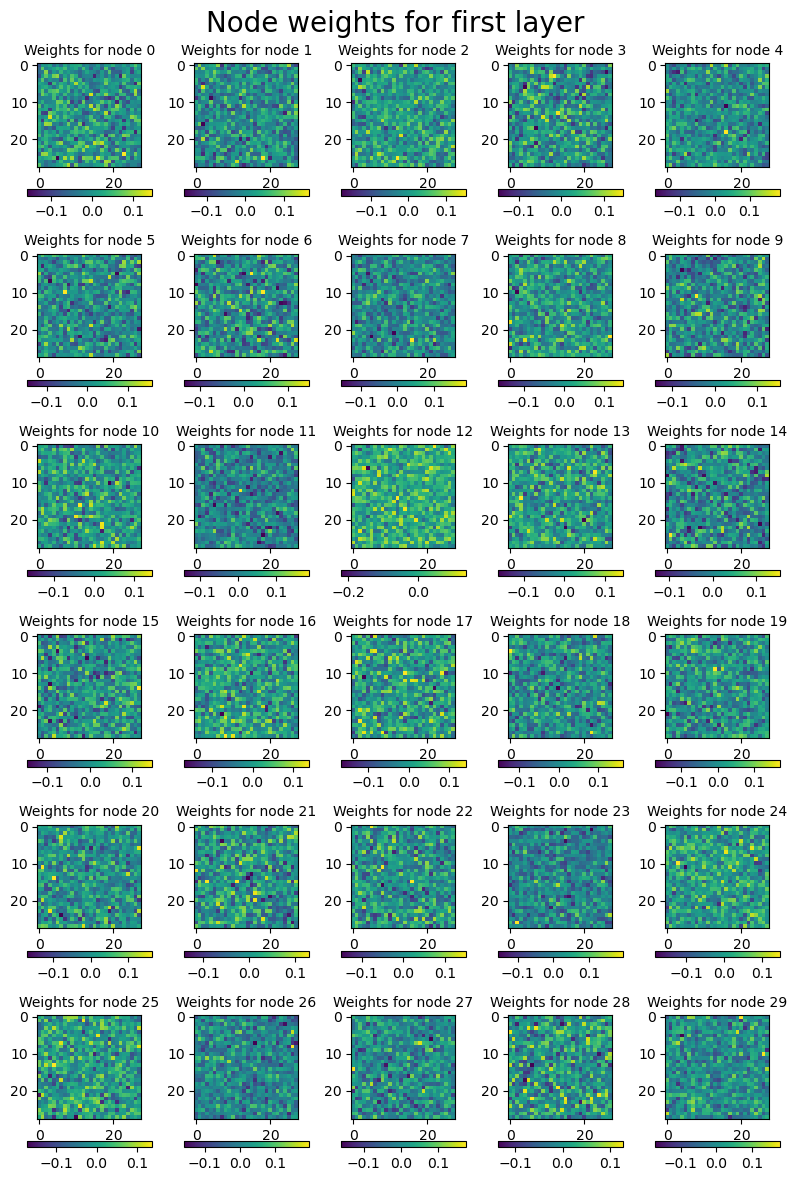

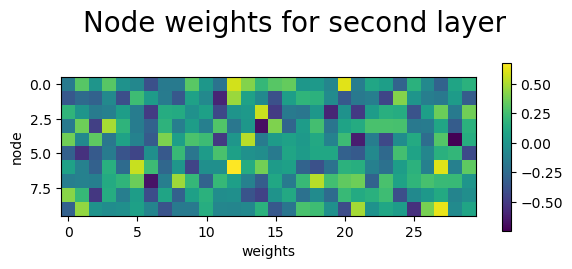

In [20]:
def NNview(layer, **kwargs):
    titleTxt = kwargs["title"]
    numIn = layer.numInputs
    numNodes = layer.numNodes
    numRows = int(np.ceil(numNodes / 5))  # number of rows of images
    if numIn == math.isqrt(numIn) ** 2:
        plt.figure(figsize=(8, int(2 * numRows)))
        plt.suptitle(titleTxt, fontsize=20)
        for i in range(numNodes):
            plt.subplot(numRows, 5, i + 1)
            imSide = int(np.sqrt(numIn))
            plt.imshow(np.reshape(layer.weights[i, :], (imSide, imSide)))
            plt.title("Weights for node " + str(i), fontsize=10)
            plt.colorbar(orientation="horizontal")
            plt.tight_layout()
    else:
        plt.figure(figsize=(6, 2.5))
        plt.suptitle(titleTxt, fontsize=20)
        plt.imshow(layer.weights)
        plt.xlabel("weights")
        plt.ylabel("node")
        plt.colorbar(orientation="vertical")
    plt.tight_layout()


NNview(network.layer1, title="Node weights for first layer")
NNview(network.layer2, title="Node weights for second layer")

# Training


To measure accuracy we will compare the output of the network, $\hat{y}$, on an image to the true label for the image, $y$. We will use an accuracy measure called cross entropy.

The **cross entropy** loss function is
\begin{equation}
L(y,\hat{y}) = -\sum_i^m y_i \log(\hat{y}\_i) = -(y_1 \log(\hat{y}\_1) + y_2 \log(\hat{y}\_2) + \cdots y_m \log(\hat{y}\_m) )
\end{equation}
where $y=(y_1,y_2,...,y_m)$ is the true value and $\hat{y} = (\hat{y}_1,\hat{y}_2,...,\hat{y}_m)$ is the predicted value.

For example, if the image is of a number 5, $y=(0,0,0,0,0,1,0,0,0,0)$ and $L(y,\hat{y})=-\log(\hat{y}_5)$. In general, for an image of a number $k$, $L(y,\hat{y})=-\log(\hat{y}_k)$.


In [21]:
# define our cross entropy loss function
def Loss(y, yHat):
    L = 0
    m = len(y)
    for i in range(m):
        # modify yHat[i] so we don't get log of zero (undefined).
        yHat[i] = max(10 ** (-10), yHat[i])
        L = L + y[i] * np.log(yHat[i])
    return -L

In [22]:
# compute and print cross entropy loss for a single sample
idx = 0
y = np.zeros(10)
y[train_labels[idx]] = 1
yHat = network.apply(train_images[idx, :, :].flatten() / 255.0)
print("Cross Entropy Loss: " + str(Loss(y, yHat)))

Cross Entropy Loss: 2.4143904087495396


### STEP 1: Compute formulas for the derivatives of the Loss function with respect to the parameters in the second layer, $W^2_{i,j}$ and $b^2_i$ for $i,j \in \{0,...,9\}$.


The derivative of the cross entropy loss function is:
\begin{equation}
\frac{d L(y,\hat{y})}{d\hat{y}\_i} = -\frac{y_i}{\hat{y}\_i}
\end{equation}


In [23]:
# derivative of Loss function with respect to the 10 inputs
def dL_dyi(y, yHat):
    m = len(y)
    output = np.zeros(m)
    for i in range(m):
        output[i] = -y[i] / yHat[i]
    return output


print(dL_dyi(y, yHat))

[ -0.          -0.          -0.          -0.          -0.
 -11.18295125  -0.          -0.          -0.          -0.        ]


Derivative of the cross entropy loss function with respect to an output of the second hidden layer is:
\begin{equation}
\frac{d L(y,\hat{y})}{d x^2*i} = \sum*{j=1}^m \frac{d L(y,\hat{y})}{d \hat{y}_j} \frac{d \hat{y}\_j}{d x^2_i} = -\sum_{j=1}^m \frac{y_j}{\hat{y}\_j} \frac{d \sigma_j(x^2)}{d x^2_i}
\end{equation}

[NOTE: The exponent on the $x$ indicates the second hidden layer. That is, $x^2_i$ is the output of the $i$-th node in the second hidden layer. Also, recall that $\hat{y}_i=\sigma_i(x)$]

(see Chain Rule: https://math.hmc.edu/calculus/hmc-mathematics-calculus-online-tutorials/multivariable-calculus/multi-variable-chain-rule/#:~:text=Multivariable%20Chain%20Rules%20allow%20us,ydydt .)


We need to derive a simple formula for this derivative. From our previous work, for $i\neq j$:
\begin{equation}
\frac{d \sigma_j(x)}{d x_i} = -\sigma_j(x)\sigma_i(x)
\end{equation}
and
\begin{equation}
\frac{d \sigma_j(x)}{d x_j} = \sigma_j(x) - \sigma_j(x)^2
\end{equation}


So the derivative of the cross entropy loss function with respect to the 10 inputs into the softmax: (recall $\hat{y}_i=\sigma_i(x^2)$)
\begin{equation}
\frac{d L(y,\hat{y})}{d x^2*i} = \sum*{j=1}^m \frac{d L(y,\hat{y})}{d \hat{y}_j} \frac{d \hat{y}\_j}{d x^2_i} = -\sum_{j=1}^m \frac{y_j}{\hat{y}\_j} \frac{d \sigma_j(x^2)}{d x^2_i} = -\left( \frac{y_1}{\hat{y}\_1}(-\hat{y}\_1\hat{y}\_i) + \cdots + \frac{y_i}{\hat{y}\_i}( \hat{y}\_i-\hat{y}\_i^2) + \cdots + \frac{y_m}{\hat{y}\_m}(-\hat{y}\_m\hat{y}\_i)\right)
\end{equation}


FINALLY, cancelling terms gives that the derivative of the cross entropy loss function with respect to the output of the $i$-th node of the second hidden layer is:
\begin{align}
\frac{d L(y,\hat{y})}{d x^2_i} &= y_1\hat{y}\_i + \cdots + y_i( \hat{y}\_i-1) + \cdots + y_m\hat{y}\_i \\
&= y_1\hat{y}\_i + \cdots + y_i\hat{y}\_i + \cdots + y_m\hat{y}\_i - y_i
\end{align}

Since only $y_i$ equals 1 for the value of $i$ corresponding to the truth label and the rest are zero, letting $k$ be the truth value gives
\begin{equation}
\frac{d L(y,\hat{y})}{d x^2_i} = \hat{y}\_i - y_i
\end{equation}

ALSO SEE: https://davidbieber.com/snippets/2020-12-12-derivative-of-softmax-and-the-softmax-cross-entropy-loss/.


In [24]:
# derivative of Loss function with respect to the 10 outputs of the second hidden layer (x_0^2,...,x_9^2)
def dL_dx2(network, obs, y):
    yHat = network.apply(obs)
    numx2i = network.layer2.numNodes
    dLdx2 = np.zeros(numx2i)
    k = np.where(y == 1)
    for i in range(numx2i):
        dLdx2[i] = yHat[i] - y[i]
    return dLdx2


idx = 0
y = np.zeros(10)
y[train_labels[idx]] = 1
obs = train_images[idx, :, :].flatten() / 255.0
print(dL_dx2(network, obs, y))

[ 0.14104607  0.08942183  0.08942183  0.08942183  0.10060545 -0.91057817
  0.13239564  0.08942183  0.08942183  0.08942183]


The output of the $i$-th node in the second layer is
\begin{equation}
x^2*i = ReLU\left( b^2_i + \sum*{j=1}^{30}W^2*{i,j}x^1_j \right) =
\begin{cases}
0 & \textrm{if} & b^2_i + \sum*{j=1}^{30}W^2*{i,j}x^1_j < 0 \\
b^2_i + \sum*{j=1}^{30}W^2*{i,j}x^1_j & \textrm{if} & b^2_i + \sum*{j=1}^{30}W^2\_{i,j}x^1_j > 0
\end{cases}
\end{equation}

The derivative of the output of the $i$-th node of layer 2 with respect to the weights of the second layer is:
\begin{equation}
\frac{d x^2*i}{dW^2*{i,j}} =
\begin{cases}
0 & \textrm{if} & x^2_i = 0 \\
x^1_j & \textrm{if} & x^2_i > 0
\end{cases}
\end{equation}

The derivative of the output of the $i$-th node of layer 2 with respect to the associated bias is:
\begin{equation}
\frac{d x^2_i}{db^2_i} =
\begin{cases}
0 & \textrm{if} & x^2_i = 0 \\
1 & \textrm{if} & x^2_i > 0
\end{cases}
\end{equation}

The derivative of the output of the $i$-th node of layer 2 with respect to the output of the $j$-th node of layer 1 is:
\begin{equation}
\frac{d x^2*i}{dx^1_j} =
\begin{cases}
0 & \textrm{if} & x^2_i = 0 \\
W^2*{i,j} & \textrm{if} & x^2_i > 0
\end{cases}
\end{equation}


Combining the with previous results,
\begin{equation}
\frac{dL(y,\hat{y})}{dW^2*{i,j}} = \frac{d L(y,\hat{y})}{d x^2_i}\frac{d x^2_i}{dW^2*{i,j}} =
\begin{cases}
0 & \textrm{if} & x^2_i = 0 \\
(\hat{y}\_i - y_i)x_j^1 & \textrm{if} & x^2_i > 0
\end{cases}
\end{equation}
and
\begin{equation}
\frac{dL(y,\hat{y})}{db^2_i} = \frac{d L(y,\hat{y})}{d x^2_i}\frac{d x^2_i}{db^2_i} =
\begin{cases}
0 & \textrm{if} & x^2_i = 0 \\
(\hat{y}\_i - y_i) & \textrm{if} & x^2_i > 0
\end{cases}
\end{equation}


In [25]:
def dL_dW2(network, obs, y):
    # the part in paranthesis (y1\hat{y1},...,ym\hat{ym})is dL_dx2:
    dLdx2 = dL_dx2(network, obs, y)
    numx2i = network.layer2.numNodes
    numx1i = network.layer1.numNodes
    # define the variable to hold the output
    # this is an array the same size as the weight matrix
    dLdW2 = np.zeros((numx2i, numx1i))
    for i in range(numx2i):
        for j in range(numx1i):
            if network.out2[i] == 0:
                dLdW2[i, j] = 0
            else:
                dLdW2[i, j] = dLdx2[i] * network.out1[j]
    return dLdW2


def dL_db2(network, obs, y):
    # the part in paranthesis (y1\hat{y1},...,ym\hat{ym})is dL_dx2:
    dLdx2 = dL_dx2(network, obs, y)
    numx2i = network.layer2.numNodes
    # define the variable to hold the output
    # this is a vector the same size as the number of nodes in layer 2
    dLdb2 = np.zeros(numx2i)
    for i in range(numx2i):
        if network.out2[i] == 0:
            dLdb2[i] = 0
        else:
            dLdb2[i] = dLdx2[i]
    return dLdb2


def dx2_dx1(network, obs, y):
    numx2i = network.layer2.numNodes
    numx1i = network.layer1.numNodes
    dx2dx1 = np.zeros((numx2i, numx1i))
    for i in range(numx2i):
        for j in range(numx1i):
            if network.out2[i] == 0:
                dx2dx1[i, j] = 0
            else:
                dx2dx1[i, j] = network.layer2.weights[i, j]
    return dx2dx1

Derivative of L with respet to the biases in the second layer: [0.14104607 0.         0.         0.         0.10060545 0.
 0.13239564 0.         0.         0.        ]


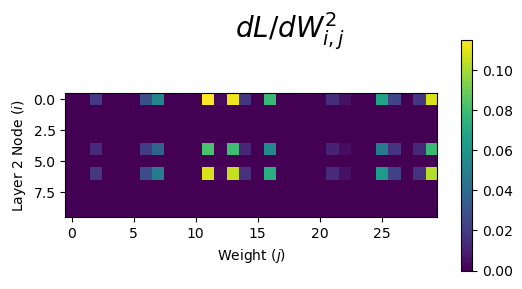

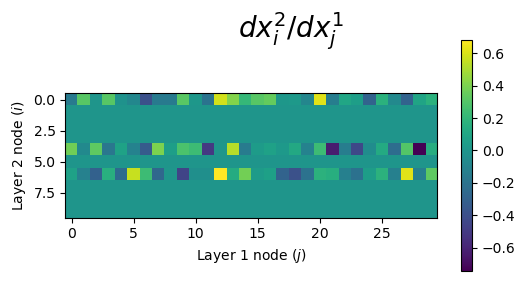

In [26]:
idx = 0
y = np.zeros(10)
y[train_labels[idx]] = 1
obs = train_images[idx, :, :].flatten() / 255.0

dLdW2 = dL_dW2(network, obs, y)
plt.figure(figsize=(6, 3))
plt.suptitle("$dL / dW^2_{i,j}$", fontsize=20)
plt.imshow(dLdW2)
plt.xlabel("Weight ($j$)")
plt.ylabel("Layer 2 Node ($i$)")
plt.colorbar(orientation="vertical")

dx2dx1 = dx2_dx1(network, obs, y)
plt.figure(figsize=(6, 3))
plt.suptitle("$dx_i^2 / dx_j^1$", fontsize=20)
plt.imshow(dx2dx1)
plt.xlabel("Layer 1 node ($j$)")
plt.ylabel("Layer 2 node ($i$)")
plt.colorbar(orientation="vertical")

dLdb2 = dL_db2(network, obs, y)
print("Derivative of L with respet to the biases in the second layer: " + str(dLdb2))

### STEP 2: Compute formulas for the derivatives of the Loss function with respect to the parameters in the first layer, $W^1_{i,j}$ and $b^1_i$ for $i \in \{0,...,30\}$ and $j \in \{0,...,784\}$.


Similar to the second layer:

The output of the $i$-th node in the first layer is
\begin{equation}
x^1*i = ReLU\left( b^1_i + \sum*{j=1}^{30}W^1*{i,j}x_j \right) =
\begin{cases}
0 & \textrm{if} & b^1_i + \sum*{j=1}^{30}W^1*{i,j}x_j < 0 \\
b^1_i + \sum*{j=1}^{30}W^1*{i,j}x_j & \textrm{if} & b^1_i + \sum*{j=1}^{30}W^1\_{i,j}x_j > 0
\end{cases}
\end{equation}

The derivative of the output of the $i$-th node of layer 1 with respect to the weights of the first layer is:
\begin{equation}
\frac{d x^1*i}{dW^1*{i,j}} =
\begin{cases}
0 & \textrm{if} & x^1_i = 0 \\
x_j & \textrm{if} & x^1_i > 0
\end{cases}
\end{equation}
and the derivative of the output of the $i$-th node of layer 2 with respect to the associated bias is:
\begin{equation}
\frac{d x^1_i}{db^1_i} =
\begin{cases}
0 & \textrm{if} & x^1_i = 0 \\
1 & \textrm{if} & x^1_i > 0
\end{cases}
\end{equation}

NOTE: Note that he derivatives of the ReLU function are very simple. This is one of the reasons we might choose this function, or a different function with similarly simple derivatives.


From the chain rule,
\begin{equation}
\frac{dL(y,\hat{y})}{dW^1*{i,j}} = \sum*{k=0}^9 \frac{d L(y,\hat{y})}{d x^2*k}\frac{d x^2_k}{d x^1_i}\frac{d x^1_i}{dW^1*{i,j}}
\end{equation}

From our previous work, the functions for the three derivatives in the chain rule are:

\begin{equation}
\frac{d L(y,\hat{y})}{d x^2_k} = \hat{y}\_k - y_k
\end{equation}

\begin{equation}
\frac{d x^2*k}{dx^1_i} =
\begin{cases}
0 & \textrm{if} & x^2_k = 0 \\
W^2*{k,i} & \textrm{if} & x^2_k > 0
\end{cases}
\end{equation}

\begin{equation}
\frac{d x^1*i}{dW^1*{i,j}} =
\begin{cases}
0 & \textrm{if} & x^1_i = 0 \\
x_j & \textrm{if} & x^1_i > 0
\end{cases}
\end{equation}

Multiplying these gives:

\begin{equation}
\frac{dL(y,\hat{y})}{dW^1*{i,j}} = \sum*{k=0}^9
\begin{cases}
0 & \textrm{if } x^2*k = 0 \textrm{ or } x^1_i = 0\\
(\hat{y}\_k - y_k) W^2*{k,i} x_j & \textrm{otherwise}
\end{cases}
\end{equation}


In [27]:
def dL_dW1(network, obs, y):
    # the part in paranthesis (y1\hat{y1},...,ym\hat{ym})is dL_dx2:
    dLdx2 = dL_dx2(network, obs, y)
    numx2i = network.layer2.numNodes
    numx1i = network.layer1.numNodes
    numInputs = network.layer1.numInputs
    # define the variable to hold the output
    # this is an array the same size as the weight matrix
    dLdW1 = np.zeros((numx1i, numInputs))
    for i in range(numx1i):
        for k in range(numx2i):
            if not (network.out2[k] == 0) or (network.out1[i] == 0):
                for j in range(numInputs):
                    dLdW1[i, j] = (
                        dLdW1[i, j] + dLdx2[k] * network.layer2.weights[k, i] * obs[j]
                    )
    return dLdW1

Similar to the previous derivation: from the chain rule,
\begin{equation}
\frac{dL(y,\hat{y})}{db^1*{i}} = \sum*{k=0}^9 \frac{d L(y,\hat{y})}{d x^2*k}\frac{d x^2_k}{d x^1_i}\frac{d x^1_i}{b^1*{i}}
\end{equation}

From our previous work, the functions for the three derivatives in the chain rule are:

\begin{equation}
\frac{d L(y,\hat{y})}{d x^2_k} = \hat{y}\_k - y_k
\end{equation}

\begin{equation}
\frac{d x^2*k}{dx^1_i} =
\begin{cases}
0 & \textrm{if} & x^2_k = 0 \\
W^2*{k,i} & \textrm{if} & x^2_k > 0
\end{cases}
\end{equation}

\begin{equation}
\frac{d x^1*i}{db^1*{i}} =
\begin{cases}
0 & \textrm{if} & x^1_i = 0 \\
1 & \textrm{if} & x^1_i > 0
\end{cases}
\end{equation}

Multiplying these gives:

\begin{equation}
\frac{dL(y,\hat{y})}{db^1*{i}} = \sum*{k=0}^9
\begin{cases}
0 & \textrm{if } x^2*k = 0 \textrm{ or } x^1_i = 0\\
(\hat{y}\_k - y_k) W^2*{k,i} & \textrm{otherwise}
\end{cases}
\end{equation}


In [28]:
def dL_db1(network, obs, y):
    # the part in paranthesis (y1\hat{y1},...,ym\hat{ym})is dL_dx2:
    dLdx2 = dL_dx2(network, obs, y)
    numx2i = network.layer2.numNodes
    numx1i = network.layer1.numNodes
    numInputs = network.layer1.numInputs
    # define the variable to hold the output
    # this is an array the same size as the weight matrix
    dLdb1 = np.zeros((numx1i))
    for i in range(numx1i):
        for k in range(numx2i):
            if not (network.out2[k] == 0) or (network.out1[i] == 0):
                dLdb1[i] = dLdb1[i] + dLdx2[k] * network.layer2.weights[k, i]
    return dLdb1

### STEP 2: Create a method for the network that will use the derivatives to adjust the weights.


In [29]:
# define the network (this time using the )
class network2layers:
    def __init__(self, layer1, layer2, layerFinal):
        self.layer1 = layer1
        self.layer2 = layer2
        self.layerFinal = layerFinal

    def apply(self, inputs):
        self.inputs = inputs
        # This determines the network 'architecture'
        self.out1 = self.layer1.apply(self.inputs)
        self.out2 = self.layer2.apply(self.out1)
        self.outFinal = self.layerFinal(self.out2)
        return self.outFinal

    def train(self, obs, y, alpha):
        #   obs = one observation (input into the network)
        #   y = the truth value for the obs
        #   alpha = the training rate
        self.layer1.weights = self.layer1.weights - alpha * dL_dW1(network, obs, y)
        self.layer1.biases = self.layer1.biases - alpha * dL_db1(network, obs, y)
        self.layer2.weights = self.layer2.weights - alpha * dL_dW2(network, obs, y)
        self.layer2.biases = self.layer2.biases - alpha * dL_db2(network, obs, y)
        # print(dL_dW2(network,obs,y))


# create an instance of this network
# (the weights will be randomly selected since it is not trained)
network = network2layers(layer1, layer2, layerFinal)

Rounds of training:


In [30]:
# make a list to hold the loss as we train
L = []

In [31]:
probability_training_single = 0
num_iters = 100
probability_training = np.zeros(int(num_iters / 20))
for i in range(num_iters):
    idx = random.randrange(num_train_images)
    y = np.zeros(10)
    y[train_labels[idx]] = 1
    obs = train_images[idx, :, :].flatten() / 255.0
    network.train(obs, y, 0.0001)

    idx = random.randrange(num_test_images)
    y = np.zeros(10)
    y[test_labels[idx]] = 1
    obs = test_images[idx, :, :].flatten() / 255.0
    yhat = network.apply(obs)
    L.append(Loss(y, yhat))
    probability_training_single = probability_training_single + yhat[test_labels[idx]]
    if (i % 20) == 0:
        print("Completed " + str(i) + " of " + str(num_iters))
        print(
            "Truth: "
            + str(test_labels[idx])
            + " | Predicted Prob: "
            + str(yhat[test_labels[idx]])
        )
        print(
            "Average Probability on Truth Class: "
            + str(probability_training_single / 20)
            + " (above 0.1 is good, close to 1 is best) "
        )
        probability_training[int(i / 20)] = probability_training_single / 20
        probability_training_single = 0

Completed 0 of 100
Truth: 6 | Predicted Prob: 0.09056559636239063
Average Probability on Truth Class: 0.004528279818119532 (above 0.1 is good, close to 1 is best) 
Completed 20 of 100
Truth: 0 | Predicted Prob: 0.15431334267394842
Average Probability on Truth Class: 0.10444020438276429 (above 0.1 is good, close to 1 is best) 
Completed 40 of 100
Truth: 9 | Predicted Prob: 0.09594480333197601
Average Probability on Truth Class: 0.10076022861631642 (above 0.1 is good, close to 1 is best) 
Completed 60 of 100
Truth: 2 | Predicted Prob: 0.09925247208341288
Average Probability on Truth Class: 0.09829785143973976 (above 0.1 is good, close to 1 is best) 
Completed 80 of 100
Truth: 1 | Predicted Prob: 0.09356353182689717
Average Probability on Truth Class: 0.09657089813586886 (above 0.1 is good, close to 1 is best) 


Text(0.5, 1.0, 'Mean Probabilty for Correct Class (over groups of 20 iterations')

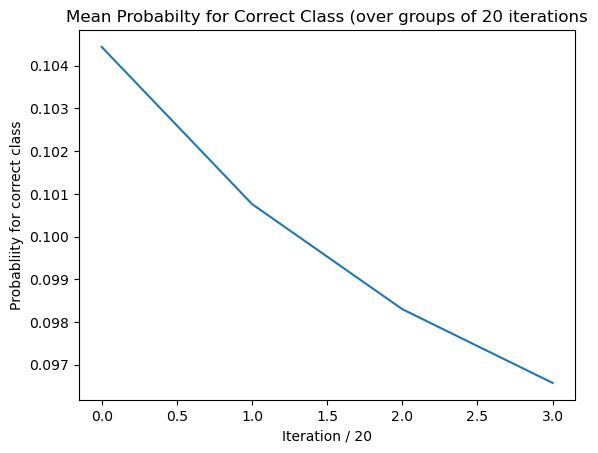

In [32]:
plt.plot(probability_training[1:])
plt.xlabel("Iteration / 20")
plt.ylabel("Probabliity for correct class")
plt.title("Mean Probabilty for Correct Class (over groups of 20 iterations")

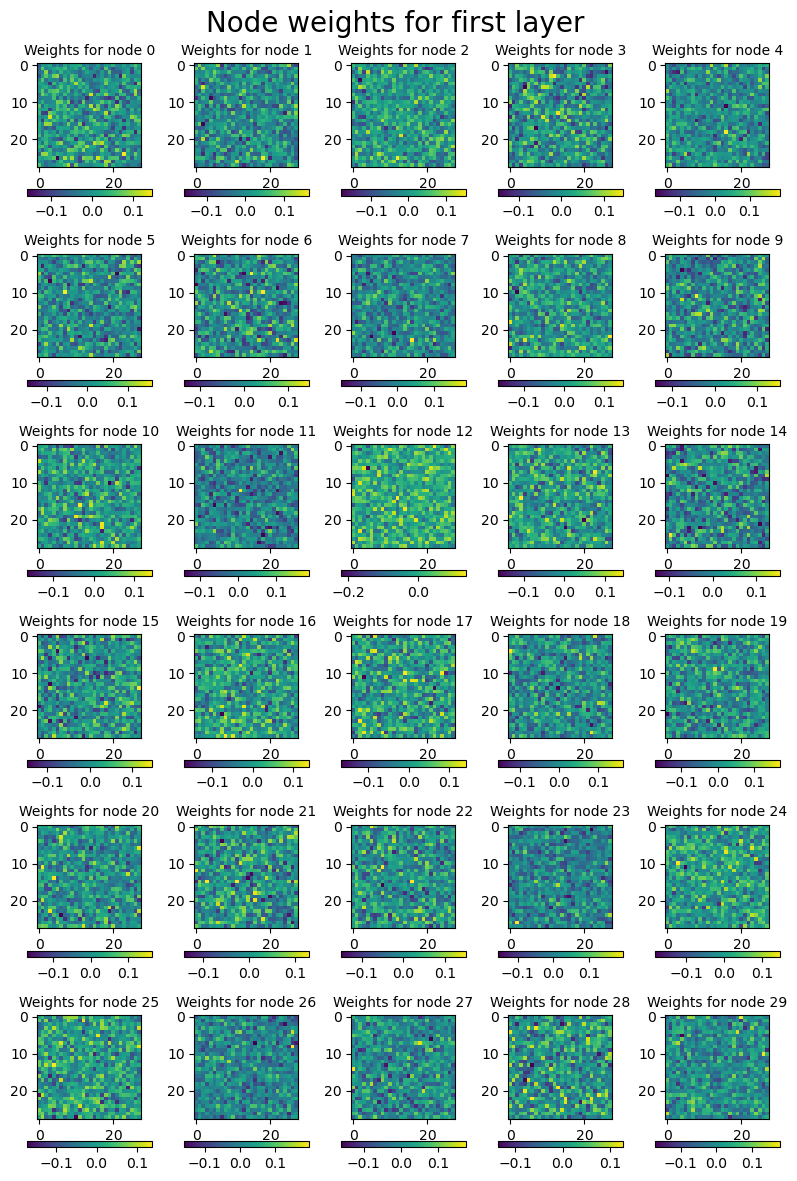

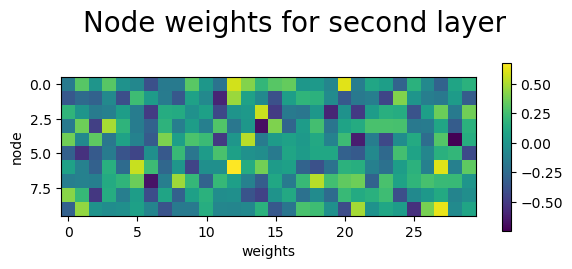

In [33]:
NNview(network.layer1, title="Node weights for first layer")
NNview(network.layer2, title="Node weights for second layer")

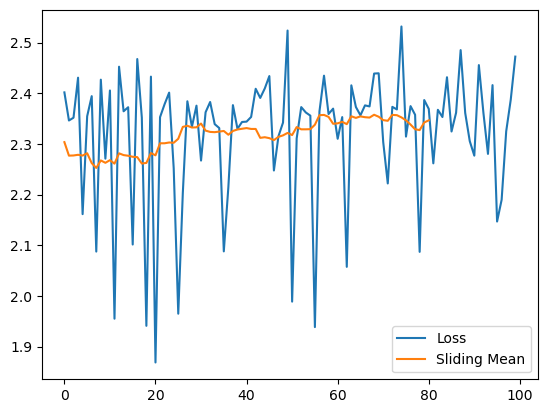

In [34]:
N = 20
plt.plot(L, label="Loss")
plt.plot(np.convolve(L, np.ones(N) / N, mode="valid"), label="Sliding Mean")
plt.legend()

Accuracy: 0.114


[Text(0, 0, '6.62983'),
 Text(0, 0, '0.444444'),
 Text(0, 0, '18.9189'),
 Text(0, 0, '26.0638'),
 Text(0, 0, '6.60377'),
 Text(0, 0, '1.5544'),
 Text(0, 0, '22.905'),
 Text(0, 0, '29.8578'),
 Text(0, 0, '0'),
 Text(0, 0, '1.62162')]

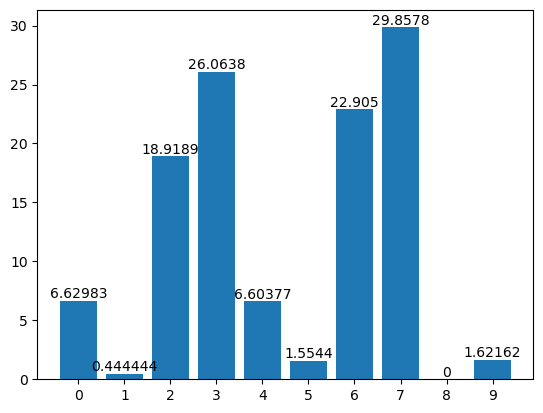

In [35]:
NumCorrect = np.zeros(10)
Num = np.zeros(10)

for idx in range(2000):
    idx = random.randrange(num_test_images)
    y = np.zeros(10)
    y[test_labels[idx]] = 1
    obs = test_images[idx, :, :].flatten() / 255.0
    yhat = network.apply(obs)
    Num[test_labels[idx]] = Num[test_labels[idx]] + 1
    if test_labels[idx] == np.argmax(yhat):
        NumCorrect[test_labels[idx]] = NumCorrect[test_labels[idx]] + 1

print("Accuracy: " + str(np.sum(NumCorrect) / np.sum(Num)))
accuracy = NumCorrect / Num
bars = plt.bar(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], accuracy * 100)
plt.bar_label(bars)

# Add MiniBatch Training


**Code definition**
This code defines a class called network2layers to represent a neural network with two hidden layers and an output layer. Each layer is defined by its own class instance (layer1, layer2, layerFinal). The apply method is used to propagate input through the network and obtain the final output.

The train method takes an observation (obs), its corresponding target truth value (y), and a learning rate (alpha). It updates the weights and biases of the network's layers using the gradients calculated by functions dL_dW1, dL_db1, dL_dW2, and dL_db2. This method is responsible for updating the network parameters using Mini-Batch Gradient Descent.

The trainMiniBatch method is used for Mini-Batch Gradient Descent. It takes a list of observations (obs_list), their corresponding target truth values (y_list), and a learning rate (alpha). It iterates through the mini-batch, accumulating gradients (deltaL_dW1, deltaL_db1, deltaL_dW2, deltaL_db2) for each observation. Then, it updates the weights and biases of the layers by averaging the accumulated gradients over the mini-batch.


In [36]:
# define the network (this time using the )
class network2layers:
    def __init__(self, layer1, layer2, layerFinal):
        self.layer1 = layer1
        self.layer2 = layer2
        self.layerFinal = layerFinal

    def apply(self, inputs):
        self.inputs = inputs
        # This determines the network 'architecture'
        self.out1 = self.layer1.apply(self.inputs)
        self.out2 = self.layer2.apply(self.out1)
        self.outFinal = self.layerFinal(self.out2)
        return self.outFinal

    def train(self, obs, y, alpha):
        #   obs = one observation (input into the network)
        #   y = the truth value for the obs
        #   alpha = the training rate
        self.layer1.weights = self.layer1.weights - alpha * dL_dW1(network, obs, y)
        self.layer1.biases = self.layer1.biases - alpha * dL_db1(network, obs, y)
        self.layer2.weights = self.layer2.weights - alpha * dL_dW2(network, obs, y)
        self.layer2.biases = self.layer2.biases - alpha * dL_db2(network, obs, y)

    def trainMiniBatch(self, obs_list, y_list, alpha):
        self.batch_size = len(y_list)
        deltaL_dW1 = 0
        deltaL_db1 = 0
        deltaL_dW2 = 0
        deltaL_db2 = 0
        for i in range(self.batch_size):
            y = y_list[i]
            obs = obs_list[i]
            deltaL_dW1 = deltaL_dW1 + dL_dW1(network, obs, y)
            deltaL_db1 = deltaL_db1 + dL_db1(network, obs, y)
            deltaL_dW2 = deltaL_dW2 + dL_dW2(network, obs, y)
            deltaL_db2 = deltaL_db2 + dL_db2(network, obs, y)
            # print(dL_dW1(network,obs,y))
        self.layer1.weights = self.layer1.weights - alpha * deltaL_dW1 / self.batch_size
        self.layer1.biases = self.layer1.biases - alpha * deltaL_db1 / self.batch_size
        self.layer2.weights = self.layer2.weights - alpha * deltaL_dW2 / self.batch_size
        self.layer2.biases = self.layer2.biases - alpha * deltaL_db2 / self.batch_size
        # print(deltaL_dW1)
        # print(deltaL_db1)
        # print(deltaL_dW2)
        # print(deltaL_db2)


# create an instance of this network
# (the weights will be randomly selected since it is not trained)
network = network2layers(layer1, layer2, layerFinal)

In [37]:
# make a list to hold the loss as we train
L = []

In [38]:
num_iters = 20
batch_size = 20
learning_rate = 0.0001  # Our desired learning rate here

for i in range(num_iters):
    batch_idx = np.random.randint(0, high=num_train_images, size=batch_size)
    y_list = []
    obs_list = []
    for idx in batch_idx:
        y = np.zeros(10)
        y[train_labels[idx]] = 1
        y_list.append(y)
        obs = train_images[idx, :, :].flatten() / 255.0
        obs_list.append(obs)
    network.trainMiniBatch(obs_list, y_list, learning_rate)

    idx = random.randrange(num_test_images)
    y = np.zeros(10)
    y[test_labels[idx]] = 1
    obs = test_images[idx, :, :].flatten() / 255.0
    yhat = network.apply(obs)
    L.append(Loss(y, yhat))
    print("Completed " + str(i) + " of " + str(num_iters), end="")
    print(
        " -- Truth: "
        + str(test_labels[idx])
        + " | Predicted Prob: "
        + str(yhat[test_labels[idx]])
    )

Completed 0 of 20 -- Truth: 9 | Predicted Prob: 0.09682519421363739
Completed 1 of 20 -- Truth: 2 | Predicted Prob: 0.09837895193240155
Completed 2 of 20 -- Truth: 8 | Predicted Prob: 0.08741350215074596
Completed 3 of 20 -- Truth: 8 | Predicted Prob: 0.09705180524500352
Completed 4 of 20 -- Truth: 9 | Predicted Prob: 0.08892161483460105
Completed 5 of 20 -- Truth: 3 | Predicted Prob: 0.11558391374548092
Completed 6 of 20 -- Truth: 7 | Predicted Prob: 0.09171320792812776
Completed 7 of 20 -- Truth: 4 | Predicted Prob: 0.0949297684184203
Completed 8 of 20 -- Truth: 9 | Predicted Prob: 0.09702155562371159
Completed 9 of 20 -- Truth: 3 | Predicted Prob: 0.0959254905281239
Completed 10 of 20 -- Truth: 2 | Predicted Prob: 0.11095355962144011
Completed 11 of 20 -- Truth: 5 | Predicted Prob: 0.1
Completed 12 of 20 -- Truth: 4 | Predicted Prob: 0.08460426907525845
Completed 13 of 20 -- Truth: 0 | Predicted Prob: 0.13418875501650682
Completed 14 of 20 -- Truth: 6 | Predicted Prob: 0.09175425520

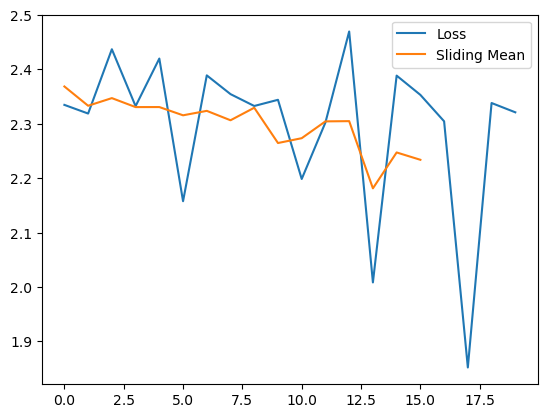

In [39]:
N = 5
plt.plot(L, label="Loss")
plt.plot(np.convolve(L, np.ones(N) / N, mode="valid"), label="Sliding Mean")
plt.legend()

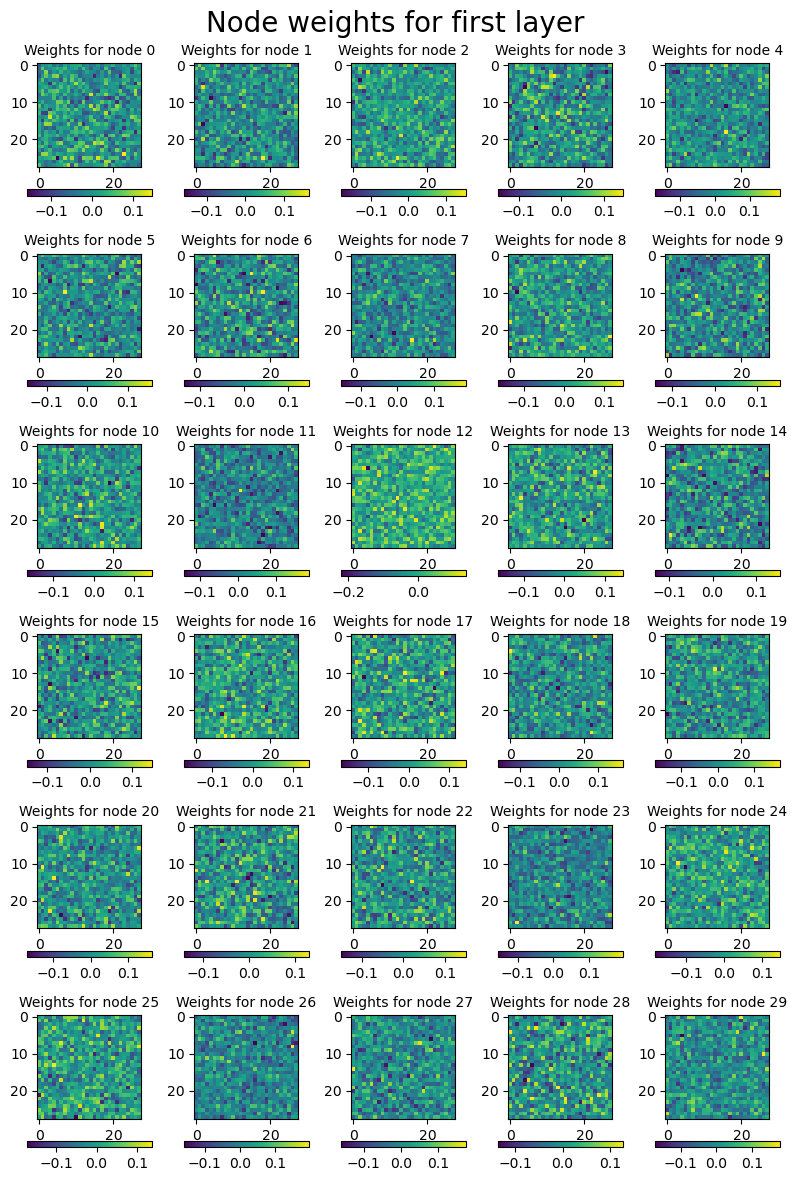

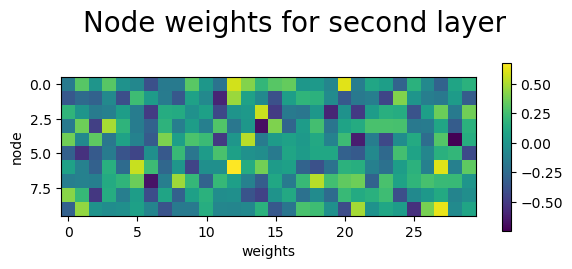

In [40]:
NNview(network.layer1, title="Node weights for first layer")
plt.savefig("20k_iterations_node_weights1.png")
NNview(network.layer2, title="Node weights for second layer")
plt.savefig("20k_iterations_node_weights2.png")

Accuracy: 0.128


[Text(0, 0, '4.94505'),
 Text(0, 0, '1.2605'),
 Text(0, 0, '19.9005'),
 Text(0, 0, '32.9949'),
 Text(0, 0, '12.9534'),
 Text(0, 0, '0.613497'),
 Text(0, 0, '18.8073'),
 Text(0, 0, '30.622'),
 Text(0, 0, '0.507614'),
 Text(0, 0, '3.46535')]

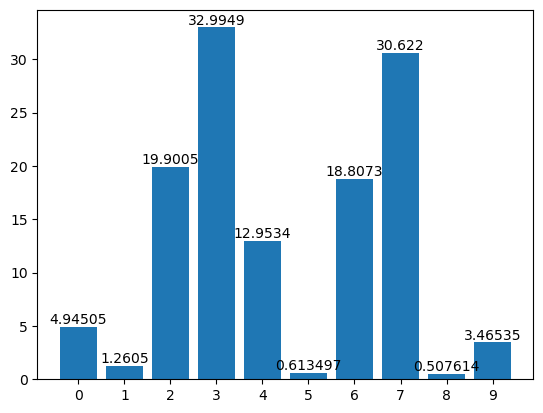

In [41]:
NumCorrect = np.zeros(10)
Num = np.zeros(10)

for idx in range(2000):
    idx = random.randrange(num_test_images)
    y = np.zeros(10)
    y[test_labels[idx]] = 1
    obs = test_images[idx, :, :].flatten() / 255.0
    yhat = network.apply(obs)
    Num[test_labels[idx]] = Num[test_labels[idx]] + 1
    if test_labels[idx] == np.argmax(yhat):
        NumCorrect[test_labels[idx]] = NumCorrect[test_labels[idx]] + 1

print("Accuracy: " + str(np.sum(NumCorrect) / np.sum(Num)))
accuracy = NumCorrect / Num
bars = plt.bar(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], accuracy * 100)
plt.bar_label(bars)

# Regularization


**Code description**
The code you provided implements a neural network with two hidden layers and regularization.
**Training with Mini-Batch and Regularization**: The `trainMiniBatch` method is used for training the network with mini-batches, which is a common technique in deep learning. This method takes a list of observations (`obs_list`), a list of truth values (`y_list`), a learning rate (`alpha`), and a regularization term (`w_decay`) as input.

- Inside the `trainMiniBatch` method, the gradients of the loss with respect to the weights and biases of each layer are computed for each observation in the mini-batch (`deltaL_dW1`, `deltaL_db1`, `deltaL_dW2`, `deltaL_db2`).

- Regularization is applied to the weight parameters of each layer. The regularization term is added to the gradient updates. In this code, L1 regularization is used, which encourages the weights to be sparse by adding the absolute values of the weights (`w_decay * np.abs(self.layer1.weights)`, `w_decay * np.abs(self.layer2.weights)`) to the gradient updates. Regularization helps prevent overfitting by discouraging large weights.


In [42]:
# define the network (this time using the )
class network2layers:
    def __init__(self, layer1, layer2, layerFinal):
        self.layer1 = layer1
        self.layer2 = layer2
        self.layerFinal = layerFinal

    def apply(self, inputs):
        self.inputs = inputs
        # This determines the network 'architecture'
        self.out1 = self.layer1.apply(self.inputs)
        self.out2 = self.layer2.apply(self.out1)
        self.outFinal = self.layerFinal(self.out2)
        return self.outFinal

    def train(self, obs, y, alpha):
        #   obs = one observation (input into the network)
        #   y = the truth value for the obs
        #   alpha = the training rate
        self.layer1.weights = self.layer1.weights - alpha * dL_dW1(network, obs, y)
        self.layer1.biases = self.layer1.biases - alpha * dL_db1(network, obs, y)
        self.layer2.weights = self.layer2.weights - alpha * dL_dW2(network, obs, y)
        self.layer2.biases = self.layer2.biases - alpha * dL_db2(network, obs, y)

    def trainMiniBatch(self, obs_list, y_list, alpha, w_decay):
        self.batch_size = len(y_list)
        deltaL_dW1 = 0
        deltaL_db1 = 0
        deltaL_dW2 = 0
        deltaL_db2 = 0
        for i in range(self.batch_size):
            y = y_list[i]
            obs = obs_list[i]
            deltaL_dW1 = deltaL_dW1 + dL_dW1(network, obs, y)
            deltaL_db1 = deltaL_db1 + dL_db1(network, obs, y)
            deltaL_dW2 = deltaL_dW2 + dL_dW2(network, obs, y)
            deltaL_db2 = deltaL_db2 + dL_db2(network, obs, y)
            # print(dL_dW1(network,obs,y))
        self.layer1.weights = self.layer1.weights - alpha * (
            w_decay * np.abs(self.layer1.weights) + deltaL_dW1 / self.batch_size
        )
        self.layer1.biases = self.layer1.biases - alpha * (
            w_decay * np.abs(self.layer1.biases) + deltaL_db1 / self.batch_size
        )
        self.layer2.weights = self.layer2.weights - alpha * (
            w_decay * np.abs(self.layer2.weights) + deltaL_dW2 / self.batch_size
        )
        self.layer2.biases = self.layer2.biases - alpha * (
            w_decay * np.abs(self.layer2.biases) + deltaL_db2 / self.batch_size
        )
        # print(deltaL_dW1)
        # print(deltaL_db1)
        # print(deltaL_dW2)
        # print(deltaL_db2)


# create an instance of this network
# (the weights will be randomly selected since it is not trained)
network = network2layers(layer1, layer2, layerFinal)

In [43]:
L = []

In [44]:
num_iters = 200
batch_size = 20
learning_rate = 0.0001  # Our desired learning rate here
w_decay = 0.001  # Our desired Regularization term

for i in range(num_iters):
    batch_idx = np.random.randint(0, high=num_train_images, size=batch_size)
    y_list = []
    obs_list = []
    for idx in batch_idx:
        y = np.zeros(10)
        y[train_labels[idx]] = 1
        y_list.append(y)
        obs = train_images[idx, :, :].flatten() / 255.0
        obs_list.append(obs)
    network.trainMiniBatch(obs_list, y_list, learning_rate, w_decay)

    idx = random.randrange(num_test_images)
    y = np.zeros(10)
    y[test_labels[idx]] = 1
    obs = test_images[idx, :, :].flatten() / 255.0
    yhat = network.apply(obs)
    L.append(Loss(y, yhat))
    print("Completed " + str(i) + " of " + str(num_iters), end="")
    print(
        " -- Truth: "
        + str(test_labels[idx])
        + " | Predicted Prob: "
        + str(yhat[test_labels[idx]])
    )

Completed 0 of 200 -- Truth: 1 | Predicted Prob: 0.08995235361163915
Completed 1 of 200 -- Truth: 2 | Predicted Prob: 0.11999047978521402
Completed 2 of 200 -- Truth: 7 | Predicted Prob: 0.12378259369977233
Completed 3 of 200 -- Truth: 8 | Predicted Prob: 0.08492918648677979
Completed 4 of 200 -- Truth: 4 | Predicted Prob: 0.12149969234038908
Completed 5 of 200 -- Truth: 5 | Predicted Prob: 0.09137348952275728
Completed 6 of 200 -- Truth: 7 | Predicted Prob: 0.089013058482742
Completed 7 of 200 -- Truth: 6 | Predicted Prob: 0.1404349331133757
Completed 8 of 200 -- Truth: 5 | Predicted Prob: 0.09343012320270798
Completed 9 of 200 -- Truth: 6 | Predicted Prob: 0.10884608232214155
Completed 10 of 200 -- Truth: 9 | Predicted Prob: 0.09523795743299489
Completed 11 of 200 -- Truth: 3 | Predicted Prob: 0.10702619127948511
Completed 12 of 200 -- Truth: 3 | Predicted Prob: 0.1356786874678211
Completed 13 of 200 -- Truth: 2 | Predicted Prob: 0.08476612036144465
Completed 14 of 200 -- Truth: 0 | 

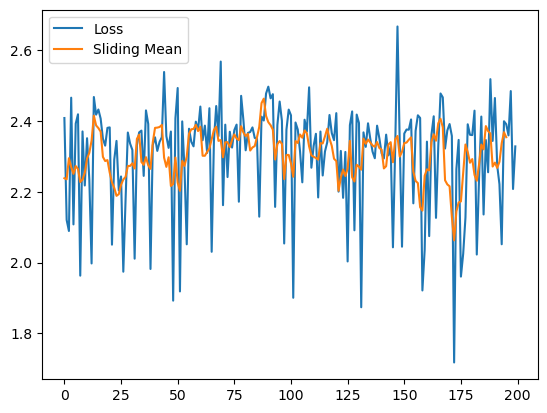

In [45]:
N = 5
plt.plot(L, label="Loss")
plt.plot(np.convolve(L, np.ones(N) / N, mode="valid"), label="Sliding Mean")
plt.legend()

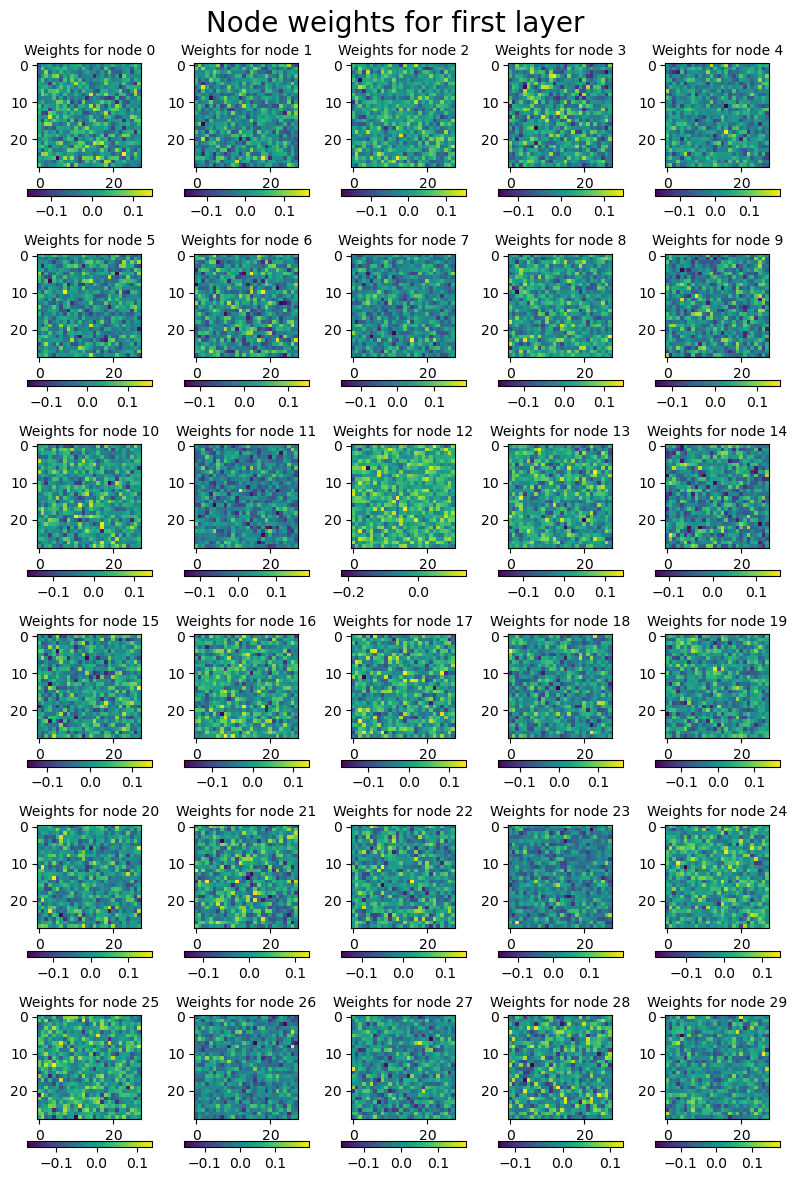

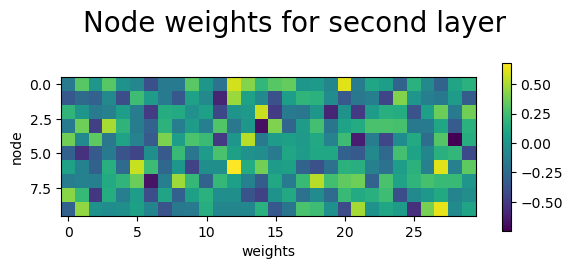

In [46]:
NNview(network.layer1, title="Node weights for first layer")
plt.savefig("20k_iterations_node_weights1.png")
NNview(network.layer2, title="Node weights for second layer")
plt.savefig("20k_iterations_node_weights2.png")

Accuracy: 0.1155


[Text(0, 0, '4.0404'),
 Text(0, 0, '0'),
 Text(0, 0, '19.469'),
 Text(0, 0, '26.6968'),
 Text(0, 0, '7.14286'),
 Text(0, 0, '1.20482'),
 Text(0, 0, '22.6804'),
 Text(0, 0, '29.2553'),
 Text(0, 0, '0'),
 Text(0, 0, '2.51256')]

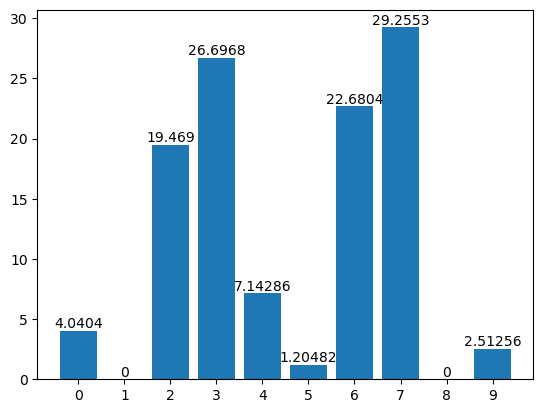

In [47]:
NumCorrect = np.zeros(10)
Num = np.zeros(10)

for idx in range(2000):
    idx = random.randrange(num_test_images)
    y = np.zeros(10)
    y[test_labels[idx]] = 1
    obs = test_images[idx, :, :].flatten() / 255.0
    yhat = network.apply(obs)
    Num[test_labels[idx]] = Num[test_labels[idx]] + 1
    if test_labels[idx] == np.argmax(yhat):
        NumCorrect[test_labels[idx]] = NumCorrect[test_labels[idx]] + 1

print("Accuracy: " + str(np.sum(NumCorrect) / np.sum(Num)))
accuracy = NumCorrect / Num
bars = plt.bar(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], accuracy * 100)
plt.bar_label(bars)